In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


In [2]:

# Load dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Preprocessing
for df in [train, test]:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

In [4]:
le = LabelEncoder()
train['cluster_id'] = le.fit_transform(train['cluster_id'])
test['cluster_id'] = le.transform(test['cluster_id'])


In [5]:
# Simpan ID
test_ids = test['ID']

In [6]:
# Drop kolom yang tidak digunakan
train = train.drop(columns=['ID', 'date'])
test = test.drop(columns=['ID', 'date'])

In [7]:
# Split data
X = train.drop(columns=['electricity_consumption'])
y = train['electricity_consumption']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:

# Train model
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# Evaluate model
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE Validation: {rmse:.4f}")

RMSE Validation: 32.2903


In [10]:
# Predict test.csv
y_test_pred = model.predict(test)


In [11]:
# Save submission
submission = pd.DataFrame({'ID': test_ids, 'electricity_consumption': y_test_pred})
submission.to_csv("submission.csv", index=False)

In [12]:
submission

,ID,electricity_consumption
0,cluster_1_2022-01-01,334.074097
1,cluster_2_2022-01-01,503.169922
2,cluster_3_2022-01-01,716.646545
3,cluster_4_2022-01-01,978.142273
4,cluster_1_2022-01-02,341.120605
...,...,...
3395,cluster_4_2024-04-28,841.799255
3396,cluster_1_2024-04-29,318.393311
3397,cluster_2_2024-04-29,458.163239
3398,cluster_3_2024-04-29,621.646851


Train RMSE: 22.822495969832605
Validation RMSE: 32.29032880767684
R2 Score: 0.9877292895338607


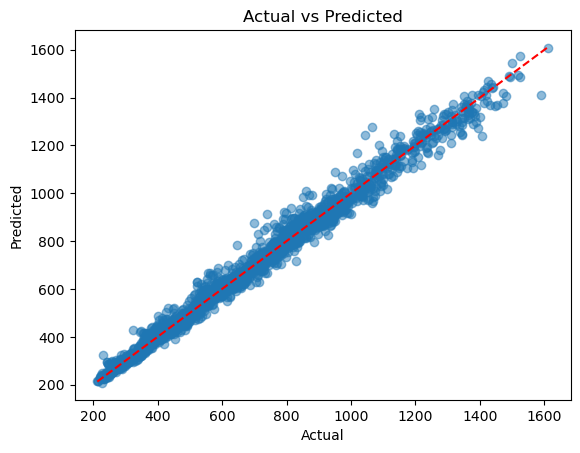

In [13]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Train dan validation scores
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_pred)))
print("R2 Score:", r2_score(y_val, val_pred))

# Visualisasi prediksi vs aktual
plt.scatter(y_val, val_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

# Cek struktur data
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
print("\nTrain Columns:", train.columns)

Train Data Shape: (11688, 15)
Test Data Shape: (3400, 14)

Train Columns: Index(['ID', 'date', 'cluster_id', 'electricity_consumption',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'sunshine_duration', 'daylight_duration',
       'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration'],
      dtype='object')


In [15]:
print("Missing Values in Train Data:")
print(train.isnull().sum())

print("\nMissing Values in Test Data:")
print(test.isnull().sum())

Missing Values in Train Data:
ID                             0
date                           0
cluster_id                     0
electricity_consumption        0
temperature_2m_max             0
temperature_2m_min             0
apparent_temperature_max       0
apparent_temperature_min       0
sunshine_duration              0
daylight_duration              0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
dtype: int64

Missing Values in Test Data:
ID                             0
date                           0
cluster_id                     0
temperature_2m_max             0
temperature_2m_min             0
apparent_temperature_max       0
apparent_temperature_min       0
sunshine_duration              0
daylight_duration              0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0

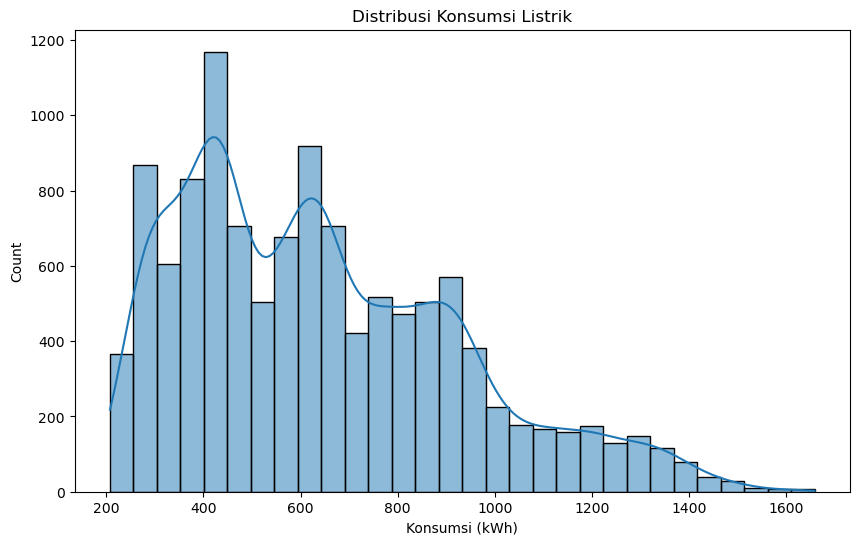

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(train['electricity_consumption'], kde=True, bins=30)
plt.title("Distribusi Konsumsi Listrik")
plt.xlabel("Konsumsi (kWh)")
plt.show()

In [21]:
# %%
# Convert date to datetime and extract features
def process_dates(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    return df.drop('date', axis=1)

In [22]:
train = process_dates(train)
test = process_dates(test)


In [24]:
train = pd.get_dummies(train, columns=['cluster_id'], prefix='cluster')
test = pd.get_dummies(test, columns=['cluster_id'], prefix='cluster')


In [27]:
# Ensure both train and test have same columns
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    if col != 'electricity_consumption':
        test[col] = 0
test = test[train.columns.drop('electricity_consumption')]

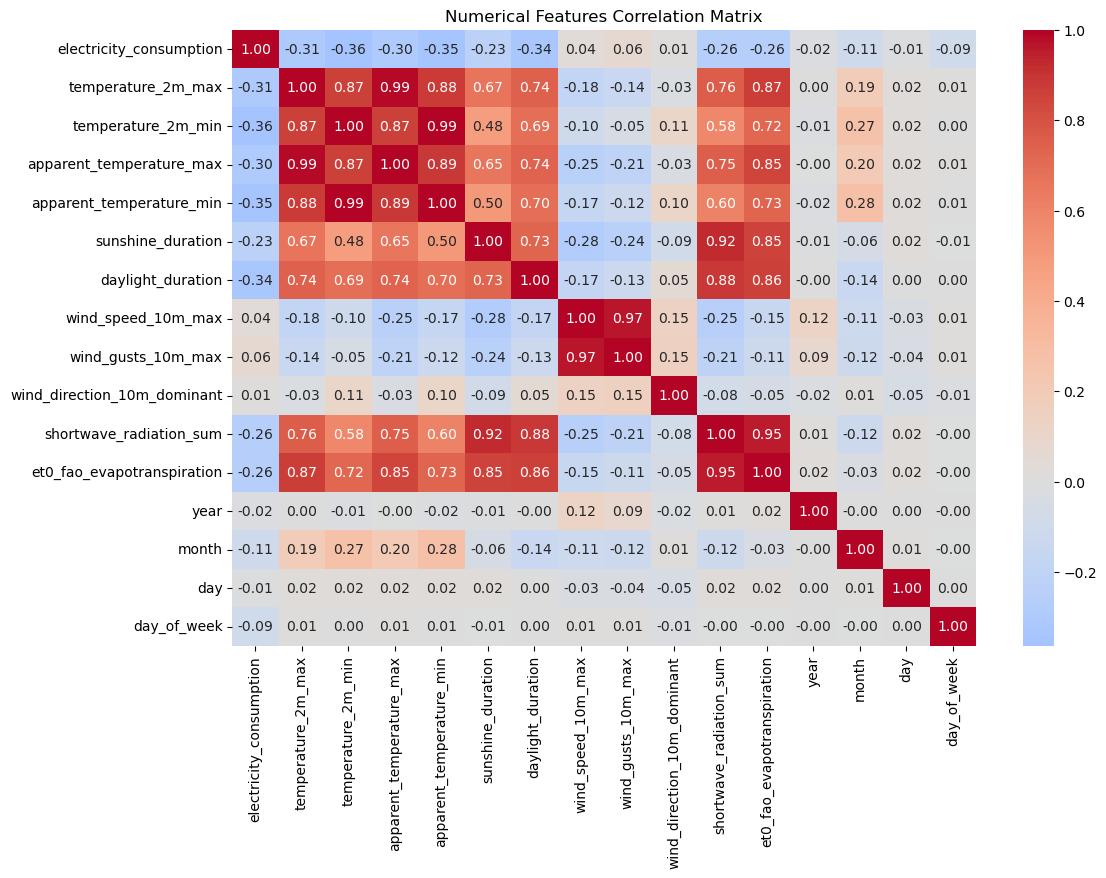

In [28]:
numerical_cols = train.select_dtypes(include=[np.number]).columns
corr_matrix = train[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Numerical Features Correlation Matrix")
plt.show()

In [29]:
# Prepare features and target
X = train.drop('electricity_consumption', axis=1)
y = train['electricity_consumption']

In [32]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)